## Object detection and semantic segmentation ##

Models included in pytorch (https://pytorch.org/vision/stable/_modules/torchvision/models/segmentation/segmentation.html)

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

fcn = models.segmentation.fcn_resnet101(pretrained=True).eval() ## We load a segmentation model from pytorch

## Lets go step by step ##

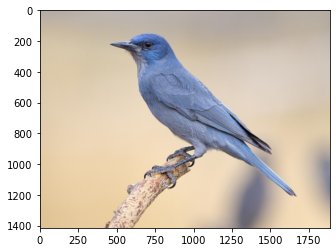

In [2]:
# Open and show the img
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


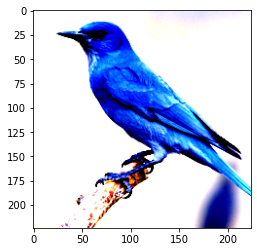

torch.Size([1, 3, 224, 224])


In [3]:
# Apply the needed transformations

trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])]) #Imagenet specific
inp = trf(img).unsqueeze(0)
plt.imshow(inp.squeeze().permute(1,2,0)); plt.show()
print(inp.shape)

In [4]:
# Pass the input through the net and get the segmentation output (same size tensor but with the 21 labels instead of channels)
out = fcn(inp)['out']
print (out.shape) # [batch_size, label_size, w, h]

torch.Size([1, 21, 224, 224])


In [5]:
# With squeeze we get rid of the 1 dimension. Argmax applied on dim=0 (after squeeze) allows us to keep max_index per pixel position
labeled_img = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (labeled_img.shape)
print (np.unique(labeled_img))

(224, 224)
[0 3]


In [7]:
# Helper function to decode the image with labels
def decode_segmap(image, nc=21):
      
    ## The model is trained on the COCO dataset, and can predict these 21 classes. Try changing colors if you want!
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l # Create a boolean array (same size) with true where image indx is same as l
        
        # fill when True
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    # Create a 3d array with rgb (w, h, channels)
    rgb = np.stack([r, g, b], axis=2)
    return rgb

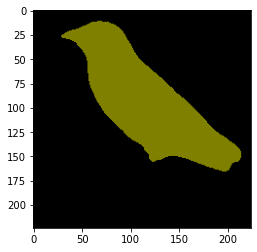

In [8]:
rgb = decode_segmap(labeled_img)
plt.imshow(rgb); plt.show()

In [9]:
## Putting it all together!

def segment(net, path):
    img = Image.open(path)
    # Show original img
    plt.imshow(img); plt.axis('off'); plt.show()
    
    trf = T.Compose([T.Resize(256), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    print (np.unique(om))
    rgb = decode_segmap(om)
    
    # Show labeled img
    plt.imshow(rgb); plt.axis('off'); plt.show()
      
    labeled = Image.fromarray(rgb).convert('RGBA') #To blend we need the Alpha channel
    src_img = img
    src_img = src_img.resize(labeled.size)
    alphaBlended1 = Image.blend(src_img.convert("RGBA"), labeled, alpha=.5)
    
    plt.imshow(alphaBlended1); plt.axis('off'); plt.show()
    
    

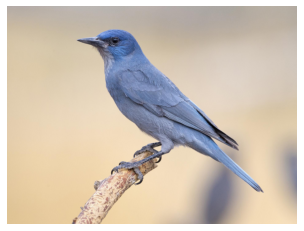

[0 3]


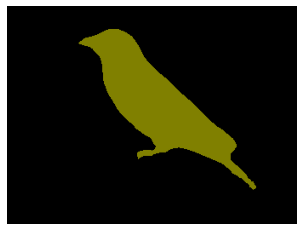

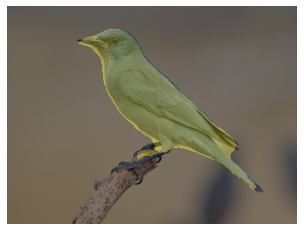

In [10]:
segment(fcn, './bird.png')

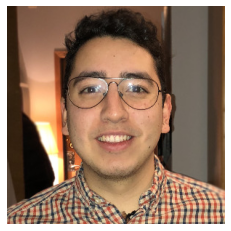

[ 0 15]


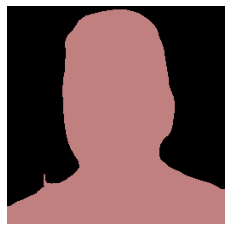

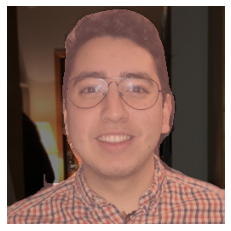

In [11]:
segment(fcn, './ai5982.jpg')

## Lets try multiple objects ##

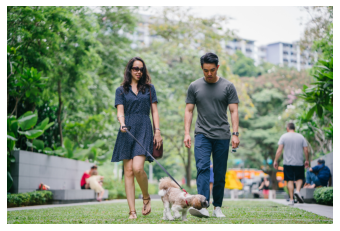

[ 0 12 15]


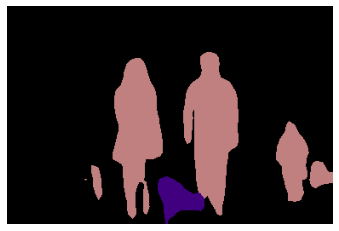

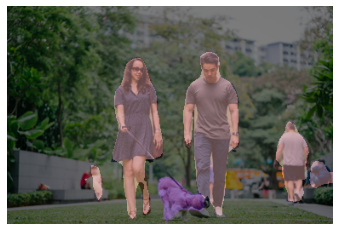

In [12]:
img = Image.open('./dog-park.png')
segment(fcn, path='./dog-park.png')

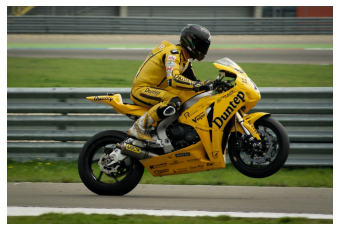

[ 0 14 15]


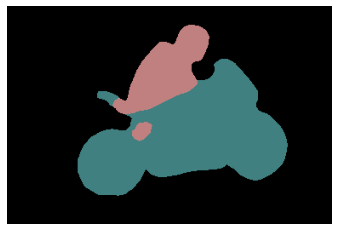

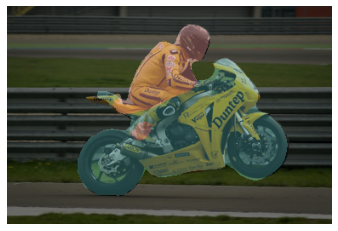

In [13]:
segment(fcn, './person-bike.jpg')

### As an exercise, using PIL Image or OpenCV, try to mask the image (cut out the people) ###